In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from os import listdir

In [2]:
#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

In [3]:
'''Load data'''

IMAGE_FOLDER = "../data/anime wallpapers"
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [4]:
def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)
        
def minibatch_image_generator(image_filenames, batch_size):
    epoch = 0 
    while 1:
        scrambled_images = np.random.permutation([misc.imread(img) for img in image_filenames])
        for batch_number in range(int(np.ceil(len(scrambled_images)/batch_size))):
            start_index = batch_number*batch_size
            end_index = min(len(scrambled_images),start_index+batch_size)
            yield epoch, scrambled_images[start_index:end_index]
        epoch = epoch + 1

In [5]:
gen = minibatch_image_generator(image_jpg_paths,1)


In [6]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride_input = [1, 2, 2, 1]):
  return tf.nn.conv2d(x, W, strides = stride_input, padding='SAME')

In [56]:
small_train = tf.placeholder('float32', shape = [None, 540, 960, 3])
large_train = tf.placeholder('float32', shape = [None, 1080, 1920, 3])

small_train_flattened = tf.reshape(small_train,[-1, 540*960*3])
large_train_flattened = tf.reshape(large_train,[-1, 1080*1920*3])

reshaped_to_image_format = tf.reshape(small_train,[-1,540,960,3])

BATCH_SIZE = 1
n_1 = 256
n_2 = 128

w_conv1 = weight_variable([2,2,3,n_1]) #7
b_conv1 = bias_variable([n_1])
h_conv1 = tf.nn.relu(conv2d(reshaped_to_image_format, w_conv1, stride_input = [1, 1, 1, 1]) + b_conv1)


w_conv2 = weight_variable([1,1,n_1,n_2]) #7
b_conv2 = bias_variable([n_2])
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, stride_input = [1, 1, 1, 1]) + b_conv2)


w_conv_inv1 = weight_variable([2,2,3,n_2])
h_conv_inv1 = tf.nn.conv2d_transpose(h_conv2, w_conv_inv1, [BATCH_SIZE,1080,1920,3], [1,2,2,1])

final = h_conv_inv1

prediction = tf.reshape(final,[-1,1080*1920*3])

MSE = tf.reduce_mean(tf.square(prediction - large_train_flattened))
pred = final
optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

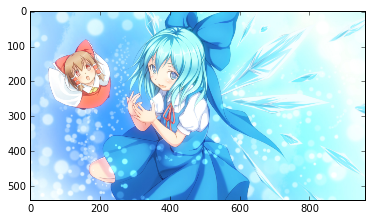

In [36]:
test_image = scipy.misc.imresize(image[0],[540,960])
plt.imshow(test_image)

In [43]:
image_gen = minibatch_image_generator(image_jpg_paths,BATCH_SIZE)

In [59]:
sess = tf.Session()
sess.run(init)

for index in range(1000):
    epoch,image_batch = next(image_gen)
    small_image = np.array([scipy.misc.imresize(img,[540,960]) for img in image_batch])
    (_,mse) = sess.run([optimizer,MSE], feed_dict={small_train:small_image, large_train:image_batch})
    if(index % 20 == 0):
        print('step = %-5d mse = %-10f' % (index,mse))
        
(sample) = sess.run(pred,feed_dict={small_train:small_image, large_train:image_batch})

step = 0     mse = 3463.109375
step = 20    mse = 1529.562012
step = 40    mse = 1047.831055
step = 60    mse = 403.415863
step = 80    mse = 143.458832
step = 100   mse = 160.191360
step = 120   mse = 80.630409 
step = 140   mse = 63.296329 
step = 160   mse = 159.675217
step = 180   mse = 20.466211 
step = 200   mse = 233.572311
step = 220   mse = 92.301796 
step = 240   mse = 35.014019 
step = 260   mse = 112.679283
step = 280   mse = 133.769699
step = 300   mse = 73.766335 
step = 320   mse = 54.934299 
step = 340   mse = 80.743065 
step = 360   mse = 196.641922
step = 380   mse = 66.759705 
step = 400   mse = 13.545280 
step = 420   mse = 84.449478 
step = 440   mse = 103.342613
step = 460   mse = 58.762939 
step = 480   mse = 193.802246
step = 500   mse = 42.020660 
step = 520   mse = 23.527260 
step = 540   mse = 39.215767 
step = 560   mse = 133.837708
step = 580   mse = 87.435692 
step = 600   mse = 21.920286 
step = 620   mse = 38.999737 
step = 640   mse = 60.018112 
step = 

In [41]:
(con) = sess.run(h_conv1,feed_dict={small_train:small_image, large_train:image_batch})
con.shape

(1, 540, 960, 64)

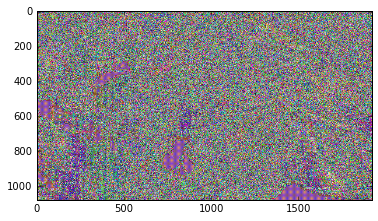

In [60]:
plt.imshow(sample[0])

In [13]:
misc.imsave("../data/anime wallpapers/generated_output/test.png",result)